*This notebook is based on the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook). The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# k-Means Clustering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

/Users/dimei/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


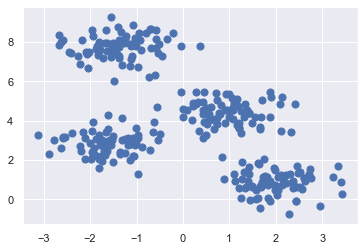

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
# cluster labels (0, 1, 2, or 3). the number itself is arbitrary
print(y_kmeans)

[3 1 2 1 3 3 0 2 1 1 0 1 2 1 3 2 2 3 0 0 3 3 2 0 0 2 3 2 0 2 1 1 2 1 1 1 1
 1 0 3 2 0 2 2 0 0 1 0 1 3 0 3 1 3 3 0 1 0 1 3 1 2 1 0 0 0 1 3 1 0 2 0 1 0
 0 1 0 2 3 1 3 2 3 3 1 2 3 2 1 1 2 3 1 0 0 2 3 3 2 0 1 3 1 3 2 3 3 2 1 2 0
 0 3 1 3 2 1 3 3 2 0 3 0 3 3 3 3 0 3 0 1 0 0 3 1 0 0 1 2 1 1 0 2 0 2 0 1 2
 1 1 1 2 1 2 3 0 1 0 3 2 1 2 2 3 2 0 0 2 3 2 2 1 3 2 0 1 3 3 2 0 3 2 0 0 2
 2 2 2 3 1 2 0 2 2 0 0 0 2 0 1 2 0 3 0 2 1 0 1 2 1 2 0 2 2 1 0 0 3 3 2 1 3
 3 0 3 0 2 1 1 2 2 1 2 3 0 2 3 0 1 0 3 2 3 1 1 1 1 0 0 1 2 0 3 2 0 0 0 3 3
 1 2 2 0 3 1 0 2 1 2 3 3 0 0 2 3 3 3 2 1 1 3 3 2 3 3 3 1 0 1 2 3 3 1 1 1 3
 3 2 1 0]


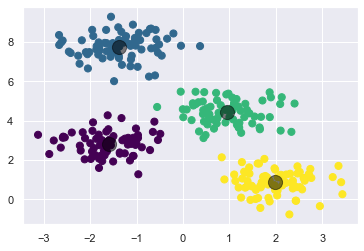

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## k-Means Algorithm: Expectation–Maximization

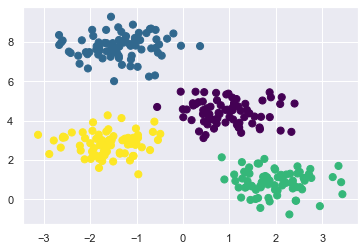

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

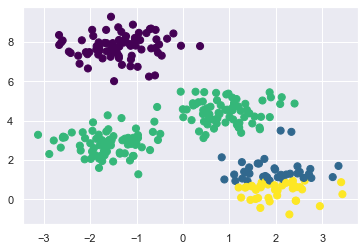

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

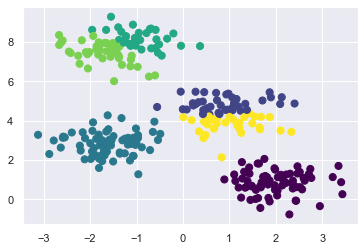

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

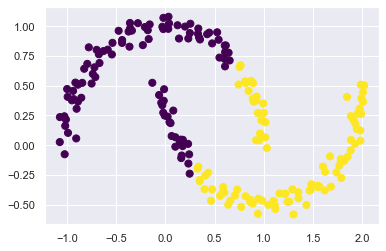

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');